## Imports

In [70]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.5f}'.format)
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(5, 5)

In [ ]:
from sklearn.linear_model import LinearRegression

In [5]:
from utils import add_remaining_useful_life

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

## Load Data

In [103]:
folder = 'data'
dataset = 'FD001'
index_cols = ['unit_number', 'time_cycle']
setting_cols = ['os_1', 'os_2', 'os_3']
sensor_cols = ['s_' + str(num) for num in range(1, 22)]
cols = index_cols + setting_cols + sensor_cols
train = pd.read_csv(os.path.join(folder, f'train_{dataset}.txt'), header=None, sep='\s+', names=cols)
train = add_remaining_useful_life(train)
X_test = pd.read_csv(os.path.join(folder, f'test_{dataset}.txt'), header=None, sep='\s+', names=cols)
y_test = pd.read_csv(os.path.join(folder, f'RUL_{dataset}.txt'), header=None, names=['RUL'])

## Data Setup

In [104]:
test_max_cycles = X_test[index_cols].groupby('unit_number').max('time_cycle').reset_index().sort_values('unit_number')
test_max_cycles['RUL'] = y_test
test = pd.merge(X_test, test_max_cycles, on=['unit_number', 'time_cycle'], how='left')
X_test_last = test.groupby('unit_number').last().reset_index()

In [105]:
drop_by_corr = False
if drop_by_corr:
    corrs = train.corr()['RUL']
    cols_to_drop = list(corrs[(np.abs(corrs) < 0.01) |
          (pd.isnull(corrs))].index.values)
else:
    cols_to_drop = []
X_train = train.drop(cols_to_drop + index_cols + ['RUL'], axis=1)
y_train = train['RUL']
X_test_last = X_test_last.drop(cols_to_drop + index_cols + ['RUL'], axis=1)

## Model

In [42]:
reg = LinearRegression()

In [43]:
reg.fit(X_train, y_train)

LinearRegression()

In [44]:
evaluate(y_train, reg.predict(X_train), label='train')
evaluate(y_test, reg.predict(X_test_last), label='test')

train set RMSE:44.660359801722706, R2:0.5795961126406295
test set RMSE:32.04109478173762, R2:0.4054954961206719


## Clip Training Values

In [49]:
max_rul = 130
y_train_clip = y_train.clip(upper=max_rul)

In [50]:
reg_clip = LinearRegression()

In [51]:
reg_clip.fit(X_train, y_train_clip)

LinearRegression()

In [52]:
evaluate(y_train, reg_clip.predict(X_train), label='train')
evaluate(y_test, reg_clip.predict(X_test_last), label='test')

train set RMSE:50.98711458542331, R2:0.4520471893378023
test set RMSE:22.06606158416156, R2:0.7180383082567376


## Examine Predictions

In [74]:
unit = 4
model = reg
train['pred'] = model.predict(X_train)
#unit_y = train.loc[train.unit_number == unit, 'RUL']
#unit_pred = train.loc[train.unit_number == unit, 'pred']

<AxesSubplot:xlabel='time_cycle'>

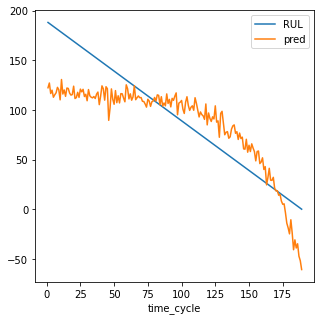

In [73]:
train[train.unit_number == unit].plot(x='time_cycle', y=['RUL', 'pred'], kind='line')

<AxesSubplot:xlabel='time_cycle'>

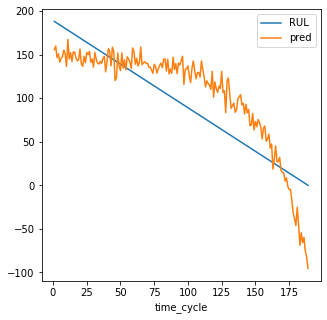

In [75]:
train[train.unit_number == unit].plot(x='time_cycle', y=['RUL', 'pred'], kind='line')